In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
#np.seterr(divide='print', invalid='print')
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import IPython
from plotly.offline import init_notebook_mode
%matplotlib inline
import plotly.offline as offline
from sklearn.calibration import CalibratedClassifierCV
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pickle

from common_functions import *

## Dataset - Loading

In [2]:
train_dataset = pd.read_csv("data/UNSW_NB15_training-set.csv", encoding = "ISO-8859-1")
train_dataset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
test_dataset = pd.read_csv("data/UNSW_NB15_testing-set.csv", encoding = "ISO-8859-1")
test_dataset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
X_train, X_cv, y_train, y_cv = train_test_split(train_dataset.drop(['attack_cat', 'label'], axis=1), train_dataset.label, stratify=train_dataset.label, test_size=0.20)
X_test, y_test = test_dataset.drop(['attack_cat', 'label'], axis=1), test_dataset.label

In [5]:
with open("binary_features", "rb") as fp:   # Unpickling binary features
    binary_features = pickle.load(fp)

with open("categorical_features", "rb") as fp:   # Unpickling categorical features
    categorical_features = pickle.load(fp)

with open("numerical_features", "rb") as fp:   # Unpickling numerical features
    numerical_features = pickle.load(fp)


In [6]:
X_train, X_cv, y_train, y_cv = train_test_split(train_dataset.drop(['label'], axis=1), train_dataset.label, stratify=train_dataset.label, test_size=0.20)
X_test, y_test = test_dataset.drop(['label'], axis=1), test_dataset.label

one_hot_encoders, one_hot_encoders_features = fit_one_hot_encoders(X_train, categorical_features)
feature_standardizers = fit_standard_scalars(X_train, numerical_features)
minmax_scalers = fit_minmax_scalars(X_train, numerical_features)

X_train_encoded, X_train_encoded_features = merge_all(X_train, 
                                                      one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_train, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_train, numerical_features, feature_standardizers), 
                                                      binary_features)

X_cv_encoded, _ = merge_all(X_cv, one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_cv, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_cv, numerical_features, feature_standardizers), 
                                                      binary_features)

X_test_encoded, _ = merge_all(X_test, one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_test, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_test, numerical_features, feature_standardizers), 
                                                      binary_features)

#label encode attack category
y_encoder = LabelEncoder().fit(y_train)
y_train = np.array(y_encoder.transform(y_train))
y_cv = np.array(y_encoder.transform(y_cv))
y_test = np.array(y_encoder.transform(y_test))

#attack categories
print('\n y classes :' + str(y_encoder.classes_))


One Hot Encoding for proto
Feature Names are :
['25', '3pc', 'aes', 'any', 'argus', 'aris', 'arp', 'ax', 'bbn', 'bna', 'br', 'cbt', 'cftp', 'chaos', 'cmtp', 'compaq', 'cphb', 'cpnx', 'crtp', 'crudp', 'dcn', 'ddp', 'ddx', 'dgp', 'egp', 'eigrp', 'emcon', 'enc', 'encap', 'etherip', 'expak', 'fc', 'fire', 'frag', 'ggp', 'gmtp', 'gre', 'hmp', 'iatp', 'ib', 'icmp', 'idp', 'idpr', 'idrp', 'ifmp', 'igmp', 'igp', 'il', 'inp', 'ip', 'ipcomp', 'ipcv', 'ipip', 'iplt', 'ipnip', 'ippc', 'ipv6', 'ipx', 'irtp', 'isis', 'iso', 'kryptolan', 'l2tp', 'larp', 'leaf', 'merit', 'mfe', 'mhrp', 'micp', 'mobile', 'mon', 'mtp', 'mux', 'narp', 'nd', 'netblt', 'nlsp', 'no', 'nsfnet', 'nsp', 'nvp', 'opts', 'ospf', 'peer', 'pgm', 'pim', 'pipe', 'pnni', 'pri', 'prm', 'ptp', 'pup', 'pvp', 'qnx', 'rcc', 'rdp', 'route', 'rpc', 'rsvp', 'rtp', 'rvd', 'sat', 'sccopmce', 'scps', 'sctp', 'sdrp', 'secure', 'sep', 'skip', 'sm', 'smp', 'snp', 'sp3', 'sprite', 'sps', 'srp', 'st2', 'stp', 'sun', 'swipe', 'tcf', 'tcp', 'tlsp', 't

#### Neural Network

Train on 140272 samples, validate on 82332 samples
Epoch 1/100
140272/140272 [==============================] - 8s 58us/sample - loss: 0.1413 - accuracy: 0.9356 - val_loss: 0.2683 - val_accuracy: 0.8347
Epoch 2/100
140272/140272 [==============================] - 6s 42us/sample - loss: 0.1199 - accuracy: 0.9409 - val_loss: 0.2786 - val_accuracy: 0.8320
Epoch 3/100
140272/140272 [==============================] - 5s 39us/sample - loss: 0.1164 - accuracy: 0.9424 - val_loss: 0.2408 - val_accuracy: 0.8464
Epoch 4/100
140272/140272 [==============================] - 6s 42us/sample - loss: 0.1148 - accuracy: 0.9432 - val_loss: 0.2746 - val_accuracy: 0.8455
Epoch 5/100
140272/140272 [==============================] - 6s 42us/sample - loss: 0.1130 - accuracy: 0.9440 - val_loss: 0.3244 - val_accuracy: 0.8291
Epoch 6/100
140272/140272 [==============================] - 5s 37us/sample - loss: 0.1118 - accuracy: 0.9452 - val_loss: 0.2912 - val_accuracy: 0.8415
Epoch 7/100
140272/140272 [==========

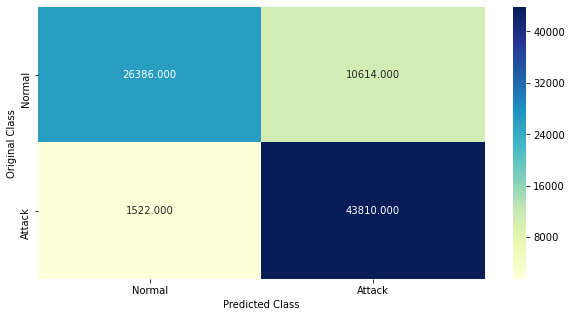

-------------------------------------------------- Precision matrix --------------------------------------------------


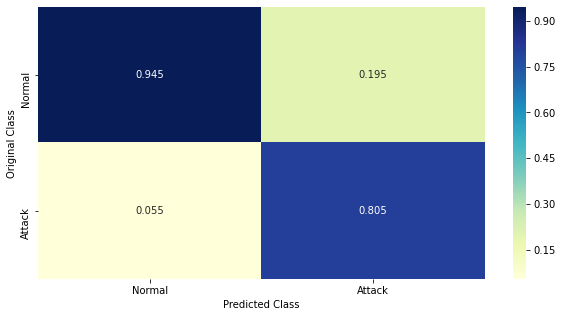

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


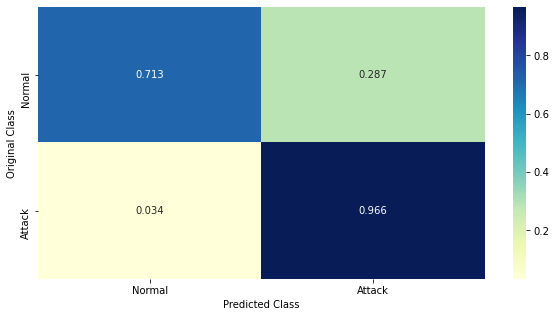

Sum of rows in precision matrix [1. 1.]


In [31]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_encoded.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_encoded.todense(), y_train, batch_size=128, epochs=100, validation_data=(X_test_encoded.todense(), y_test))

print ("The train log loss is:", log_loss(y_train, model.predict_proba(X_train_encoded.todense()), eps=1e-7))
predict_y = tree.predict_proba(X_cv_encoded)
print("The cross validation log loss is:", log_loss(y_cv, model.predict_proba(X_cv_encoded.todense()), eps=1e-7))
predict_y = tree.predict_proba(X_test_encoded)
print("The test log loss is:", log_loss(y_test, model.predict_proba(X_test_encoded.todense()), eps=1e-7))

plot_confusion_matrix(y_test, [int(np.round(x)) for x in model.predict_proba(X_test_encoded.todense())])

#storing model
model_labels['nn'] = model

In [ ]:
model_labels['nn'] = None
with open("nid_models", "wb") as fp:   #Pickling
    pickle.dump(model_labels, fp)